<a href="https://colab.research.google.com/github/agatan/Building-OCR-System-TechBookFest6/blob/master/techbook6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%sh
apt -qq -y update
apt -qq -y install fonts-ipafont
fc-list :lang=ja
pip install tensorflow-gpu==2.0.0a0

123 packages can be upgraded. Run 'apt list --upgradable' to see them.
fonts-ipafont is already the newest version (00303-18ubuntu1).
The following package was automatically installed and is no longer required:
  libnvidia-common-410
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 123 not upgraded.
/usr/share/fonts/opentype/ipafont-mincho/ipam.ttf: IPAMincho,IPA明朝:style=Regular
/usr/share/fonts/opentype/ipafont-gothic/ipagp.ttf: IPAPGothic,IPA Pゴシック:style=Regular
/usr/share/fonts/opentype/ipafont-mincho/ipamp.ttf: IPAPMincho,IPA P明朝:style=Regular
/usr/share/fonts/opentype/ipafont-gothic/ipag.ttf: IPAGothic,IPAゴシック:style=Regular
/usr/share/fonts/truetype/fonts-japanese-mincho.ttf: IPAMincho,IPA明朝:style=Regular
/usr/share/fonts/truetype/fonts-japanese-gothic.ttf: IPAGothic,IPAゴシック:style=Regular
  Found existing installation: tb-nightly 1.14.0a20190319
    Uninstalling tb-nightly-1.14.0a20190319:
      Successfully uninstalled tb-nightly-1.14.0a20190319


In [2]:
from typing import List, NamedTuple, Tuple
import subprocess
import random
import functools
import os

import numpy as np
import cv2
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt
import tensorflow as tf
L = tf.keras.layers

from google.colab import drive

drive.mount("/drive")
rootdir = "/drive/My Drive/techbook6"
os.makedirs(rootdir, exist_ok=True)

Drive already mounted at /drive; to attempt to forcibly remount, call drive.mount("/drive", force_remount=True).


In [3]:
fontnames = subprocess.run("fc-list :lang=ja | sed  -r -e 's/^(.+): .*$/\\1/g'", stdout=subprocess.PIPE, shell=True).stdout.decode("utf-8").strip().split("\n")
fontnames

['/usr/share/fonts/opentype/ipafont-mincho/ipam.ttf',
 '/usr/share/fonts/opentype/ipafont-gothic/ipagp.ttf',
 '/usr/share/fonts/opentype/ipafont-mincho/ipamp.ttf',
 '/usr/share/fonts/opentype/ipafont-gothic/ipag.ttf',
 '/usr/share/fonts/truetype/fonts-japanese-mincho.ttf',
 '/usr/share/fonts/truetype/fonts-japanese-gothic.ttf']

In [0]:
CHARACTERS = list("ぁあぃいぅうぇえぉおかがきぎくぐけげこごさざしじすずせぜそぞただちぢっつづてでとどなにぬねのはばぱひびぴふぶぷへべぺほぼぽまみむめもゃやゅゆょよらりるれろゎわゐゑをんァアィイゥウェエォオカガキギクグケゲコゴサザシジスズセゼソゾタダチヂッツヅテデトドナニヌネノハバパヒビピフブプヘベペホボポマミムメモャヤュユョヨラリルレロヮワヰヱヲンヴヵヶabcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789!#$%&()*+-./:<=>?@[\]^_{}~ー々")
def random_text(length: int) -> str:
    return "".join(random.choices(CHARACTERS, k=length))

In [0]:
class TextBox(NamedTuple):
    text: str
    xmin: int
    ymin: int
    xmax: int
    ymax: int

[TextBox(text='つつェS:', xmin=122, ymin=122, xmax=178, ymax=134), TextBox(text='トXゥュこiェ4', xmin=87, ymin=58, xmax=178, ymax=70), TextBox(text='ソ6ヤスちuラ', xmin=44, ymin=189, xmax=147, ymax=205), TextBox(text='れぼ', xmin=65, ymin=88, xmax=81, ymax=95), TextBox(text='イセdEWsう', xmin=46, ymin=109, xmax=123, ymax=123), TextBox(text='げ\\ぞア>ィ々マ', xmin=108, ymin=171, xmax=172, ymax=181), TextBox(text='dヴヤろセ', xmin=88, ymin=85, xmax=160, ymax=99), TextBox(text='ブみ@ソ#パi', xmin=35, ymin=213, xmax=79, ymax=221)]


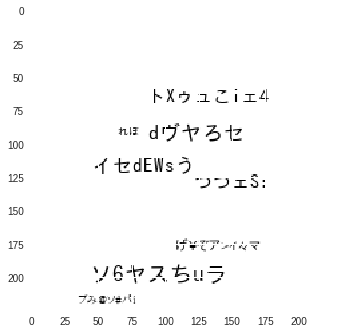

In [19]:
def generate(width: int, height: int) -> Tuple[Image.Image, List[TextBox]]:
    image = Image.new("RGB", (width, height), color=(255, 255, 255))
    draw = ImageDraw.Draw(image)
    used_map = np.zeros((height, width), dtype=np.bool)
    retry_count = 0
    boxes: List[TextBox] = []

    while retry_count < 10:
        retry_count += 1
        fontname = np.random.choice(fontnames)
        fontsize = np.random.randint(8, 20)
        font = ImageFont.truetype(fontname, fontsize)
        text_length = np.random.randint(2, 12)
        text = random_text(text_length)
        textsize_x, textsize_y = draw.textsize(text, font=font)
        if width <= textsize_x or height <= textsize_y:
            continue
        x = np.random.randint(0, width - textsize_x)
        y = np.random.randint(0, height - textsize_y)
        already_used_pixels_count = np.sum(used_map[y : y + textsize_y, x : x + textsize_x])
        if already_used_pixels_count > 0.02 * textsize_x * textsize_y:
            continue
        retry_count = 0
        used_map[y : y + textsize_y, x : x + textsize_x] = True
        draw.text((x, y), text, fill=(0, 0, 0), font=font)
        boxes.append(TextBox(text=text, xmin=x, ymin=y, xmax=x + textsize_x, ymax=y + textsize_y))
        if np.sum(used_map) > np.random.random() * width * height:
            break

    return image, boxes

image, bbs = generate(224, 224)
print(bbs)
plt.imshow(image)
train_images: List[Image.Image] = []
train_bboxes: List[List[TextBox]] = []
SIZE = 1000
WIDTH = 224
HEIGHT = 224
for _ in range(SIZE):
    img, bbs = generate(width=WIDTH, height=HEIGHT)
    train_images.append(img)
    train_bboxes.append(bbs)

## Detector

### Define input pipeline for detector

In [0]:
def _detection_data_generator_fn():
    def fn():
        for i in range(SIZE):
            image, boxes = train_images[i], train_bboxes[i]
            points = [
                [[box.xmin, box.ymin], [box.xmin, box.ymax], [box.xmax, box.ymax], [box.xmax, box.ymin]]
                for box in boxes
            ]
            yield np.asarray(image), np.asarray(points)
    return fn


def _generate_pixel_score_and_links(image, points, scale):
    # type: (tf.Tensor, tf.Tensor, int) -> Tupel[tf.Tensor, tf.Tensor]
    """
    Args:
        image: (H, W, 3)
        points: (N, 4, 2)
    Returns:
        score: boolean tensor of shape (H / scale, W / scale).
        links: boolean tensor of shape (8, H / scale, W / scale).
        weights: float32 tensor of shape (H / scale, W / scale).
    """
    height, width = tf.shape(image)[0], tf.shape(image)[1]
    score_height = height // scale
    score_width = width // scale
    score = np.zeros((score_height, score_width), np.uint8)
    sum_area = 0
    weights_map = np.zeros((score_height, score_width), np.float32)
    for pts in points.numpy():
        pts = pts // scale
        score_tmp = np.zeros_like(score)
        cv2.fillPoly(score_tmp, [pts], color=1)
        area = np.sum(score_tmp)
        sum_area += area
        weights_map[score_tmp == 1] = area
        score += score_tmp
    score = np.where(score == 1, score, np.zeros_like(score))
    weights_map = np.where(
        score == 1,
        sum_area / (points.shape[0] + 1e-7) / (weights_map + 1e-7),
        np.zeros_like(weights_map),
    )
    padded_score = np.pad(score, [[1, 1], [1, 1]], "constant")
    links: List[np.ndarray] = []
    for y in range(3):
        for x in range(3):
            if y == 1 and x == 1:
                continue
            tmp = padded_score[y : y + score.shape[0], x : x + score.shape[1]]
            links.append((tmp * score).astype(np.bool))
    return (
        tf.convert_to_tensor(score.astype(np.bool)),
        tf.convert_to_tensor(links),
        tf.convert_to_tensor(weights_map),
    )



def make_detection_dataset(batch_size, scale=2, training=False):
    # type: (int, int, int, int, int, bool) -> tf.data.Dataset
    
    dataset = tf.data.Dataset.from_generator(
        _detection_data_generator_fn(),
        output_types=(tf.uint8, tf.int32)
    )
    dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
    if training:
        dataset = dataset.shuffle(batch_size * 10)
    
    def map_fn(image, points):
        # type: (tf.Tensor, tf.Tensor) -> Tuple[tf.Tensor, Dict[str, tf.Tensor]]
        image = tf.cast(image, tf.float32) / 127.5 - 1  # normalize pixels into -1~1
        score, links, weight = tf.py_function(
            functools.partial(_generate_pixel_score_and_links, scale=scale),
            inp=[image, points],
            Tout=[tf.bool, tf.bool, tf.float32],
        )
        return image, {"score": score, "links": links, "weight": weight}

    dataset = dataset.map(map_fn, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    # Remove images that have no positive pixels.
    dataset = dataset.filter(lambda image, labels: tf.reduce_sum(labels["weight"]) > 0.0)
    dataset = dataset.batch(batch_size)
    return dataset


### Define Detector Network

PixelLink の Backbone は原論文では VGG16 などが使われているが、今回は CPU での推論をやりたい気持ちがあったので、軽量・高速な MobileNetV2 を使ってみます。

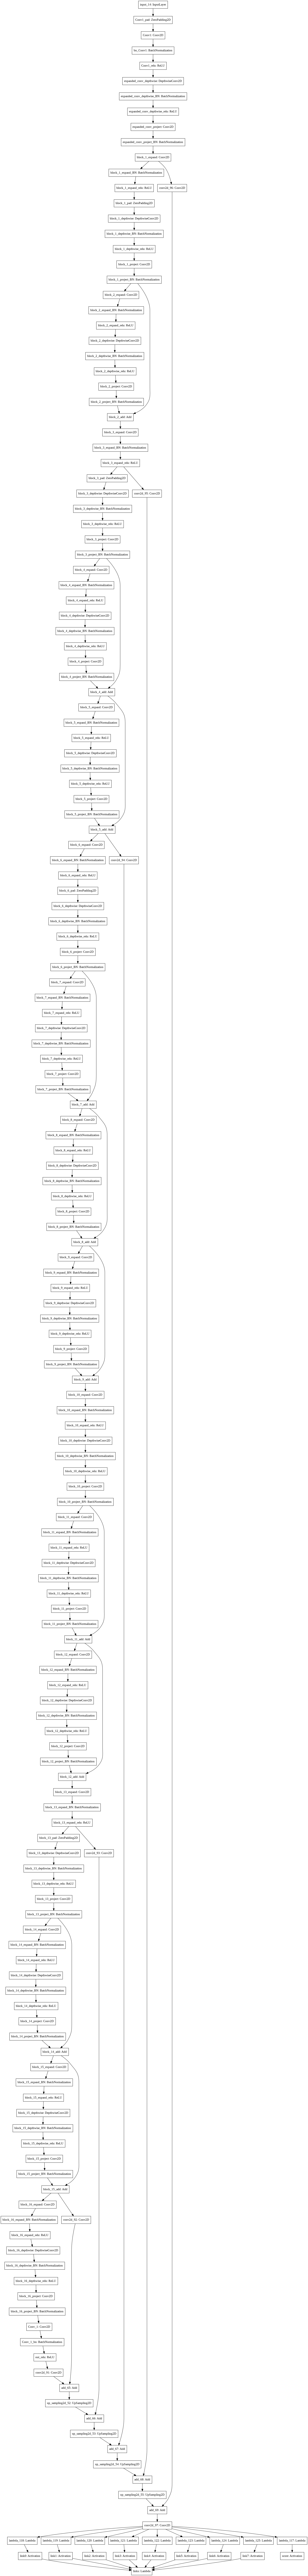

In [74]:
def _fuse_features(filters, x1, x2, upsample=True):
    # type: (int, tf.Tensor, tf.Tensor, bool) -> tf.Tensor
    if upsample:
        x1 = L.UpSampling2D()(x1)
    else:
        x1 = L.Conv2D(filters, 1)(x1)
    x2 = L.Conv2D(filters, 1)(x2)
    return L.add([x1, x2])


def PixelLink(input_shape=(224, 224, 3)):
    mobilenetv2 = tf.keras.applications.MobileNetV2(input_shape=input_shape, include_top=False, weights=None)
    inputs = mobilenetv2.input
    filters = 1 + 8  # pixel score, nerighbor links
    x = _fuse_features(
        filters, mobilenetv2.output, mobilenetv2.get_layer(index=-12).output, upsample=False
    )
    x = _fuse_features(filters, x, mobilenetv2.get_layer(index=-36).output)
    x = _fuse_features(filters, x, mobilenetv2.get_layer(index=-101).output)
    x = _fuse_features(filters, x, mobilenetv2.get_layer(index=-125).output)
    x = _fuse_features(filters, x, mobilenetv2.get_layer(index=-145).output)
    x = L.Conv2D(filters, 1)(x)
    scores = L.Lambda(lambda t: t[..., 0])(x)
    scores = L.Activation("sigmoid", name="score")(scores)
    outputs: List[tf.Tensor] = [scores]
    link_list: List[tf.Tensor] = []
    for i in range(8):
        link = L.Lambda(lambda t: t[..., i + 1])(x)
        link = L.Activation("sigmoid", name="link{}".format(i))(link)
        link_list.append(link)
    links = L.Lambda(lambda t: tf.stack(t, axis=1), name="links")(link_list)
    outputs = [scores, links]
    return tf.keras.Model(inputs, outputs)

model = PixelLink()
tf.keras.utils.plot_model(model)

### Define loss functions

損失関数を定義します

In [0]:
def loss_fn(score_true, score_pred, links_true, links_pred, weights, r=3):
    # type: (tf.Tensor, tf.Tensor, tf.Tensor, tf.Tensor, tf.Tensor, int) -> (tf.Tensor, tf.Tensor)
    batch = tf.shape(score_true)[0]
    n_pixels = tf.shape(score_true)[1] * tf.shape(score_pred)[2]
    score_true = tf.reshape(score_true, (batch, n_pixels, 1))
    score_pred = tf.reshape(score_pred, (batch, n_pixels, 1))
    links_true = tf.reshape(links_true, (batch, 8, n_pixels, 1))
    links_pred = tf.reshape(links_pred, (batch, 8, n_pixels, 1))
    weights = tf.reshape(weights, (batch, n_pixels))
    positive_mask = tf.cast(weights > 0.0, tf.int32)
    n_positive_pixels = tf.reduce_sum(positive_mask, axis=1)
    negative_mask = 1 - positive_mask

     # ==== Select hard negative examples
    score_ce = tf.keras.losses.binary_crossentropy(score_true, score_pred)
    n_hard_examples = tf.minimum(n_positive_pixels * r, n_pixels - n_positive_pixels)
    negative_score_ce = score_ce * tf.cast(negative_mask, tf.float32)
    sorted_negative_ce = tf.sort(negative_score_ce, axis=-1, direction="DESCENDING")
    hard_negative_threshold = tf.map_fn(
        lambda args: args[1][args[0]],
        elems=[n_hard_examples, sorted_negative_ce],
        dtype=tf.float32,
    )
    hard_negative_mask = negative_score_ce >= hard_negative_threshold[:, tf.newaxis]
    weights = tf.where(hard_negative_mask, tf.ones_like(weights), weights)
    # === Score Loss
    score_loss = tf.reduce_sum(
        1.0
        / (
            ((1.0 + float(r)) * tf.cast(n_positive_pixels[:, tf.newaxis], tf.float32))
            + 1e-7
        )
        * weights
        * score_ce
    )
    # === Link Loss
    links_ce = tf.keras.losses.binary_crossentropy(links_true, links_pred)
    weights_pos_links = weights[:, tf.newaxis, :, tf.newaxis] * tf.cast(links_true, tf.float32)
    weights_neg_links = weights[:, tf.newaxis, :, tf.newaxis] * (
        1.0 - tf.cast(links_true, tf.float32)
    )
    links_pos_ce = links_ce[:, :, :, tf.newaxis] * weights_pos_links
    links_neg_ce = links_ce[:, :, :, tf.newaxis] * weights_neg_links
    links_loss = tf.reduce_sum(
        links_pos_ce
        / (
            tf.reduce_sum(weights_pos_links, axis=(1, 2))[:, tf.newaxis, tf.newaxis]
            + 1e-7
        )
        + links_neg_ce
        / (
            tf.reduce_sum(weights_neg_links, axis=(1, 2))[:, tf.newaxis, tf.newaxis]
            + 1e-7,
        )
    )
    return score_loss, links_loss

### Train Detector

In [77]:
model = PixelLink()
optimizer = tf.keras.optimizers.Adam()
BATCH_SIZE = 8

metrics = {
    "loss": tf.keras.metrics.Mean(name="loss"),
    "pixel/auc": tf.keras.metrics.AUC(name="pixel/auc"),
    "link/auc": tf.keras.metrics.AUC(name="link/aux"),
}


def get_loss(images, labels):
    score_pred, link_pred = model(images)
    score_loss, link_loss = loss_fn(
        labels["score"], score_pred, labels["links"], link_pred, labels["weight"]
    )
    loss = score_loss + 2.0 * link_loss
    metrics["loss"](loss)
    metrics["pixel/auc"](labels["score"], score_pred)
    metrics["link/auc"](labels["links"], link_pred)
    return loss


@tf.function
def train_step(images, labels):
    with tf.GradientTape() as tape:
        loss = get_loss(images, labels)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))


def train():
    dataset = make_detection_dataset(BATCH_SIZE)
    for images, labels in dataset:
        images.set_shape((None, None, None, 3))
        with tf.GradientTape() as tape:
            loss = get_loss(images, labels)
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        
        
for epoch in range(3):
    print("Epoch {}".format(epoch))
    train()
    for k, m in metrics.items():
        tf.print("Step", optimizer.iterations, ":", k, ":", m.result())

Epoch 0
Step 125 : loss : 13.3581123
Step 125 : pixel/auc : 0.927991211
Step 125 : link/auc : 0.952437162
Epoch 1
Step 250 : loss : 9.91784477
Step 250 : pixel/auc : 0.967515767
Step 250 : link/auc : 0.972959757
Epoch 2
Step 375 : loss : 8.59169769
Step 375 : pixel/auc : 0.978166282
Step 375 : link/auc : 0.979374409


In [0]:
model.save_weights(os.path.join(rootdir, "detector_weights.h5"))

### Run detector

PixelLink ベースの Detector が学習できたので結果を見てみます。
PixelLink では CNN の forward に加えて、ピクセルを連結していく処理を書く必要があります。

In [0]:
def _link_pixels(pixel_mask: np.ndarray, link_mask: np.ndarray) -> np.ndarray:
    """Link positive pixels.
    Args:
        pixel_mask: uint8 array of shape [H, W]
        link_mask: uint8 array of shape [8, H, W]
    Returns:
        link_map: int array of shape [H, W]. If the pixel (x, y)
                  is linked to i-th group, link_map[y, x] = i.
    """
    union_find: Dict[Tuple[int, int], Tuple[int, int]] = {}

    def find_root(p):
        if union_find.get(p, p) == p:
            union_find[p] = p
            return p
        root = find_root(union_find[p])
        union_find[p] = root
        return root

    def link(p1, p2):
        root1 = find_root(p1)
        root2 = find_root(p2)
        if root1 != root2:
            union_find[root1] = root2

    def neighbors(y, x):
        return [
            (y - 1, x - 1),
            (y - 1, x),
            (y - 1, x + 1),
            (y, x - 1),
            (y, x + 1),
            (y + 1, x - 1),
            (y + 1, x),
            (y + 1, x + 1),
        ]

    def is_valid_coor(y, x, h, w):
        return 0 <= y < h and 0 <= x < w

    mask_height, mask_width = pixel_mask.shape
    points = list(zip(*np.where(pixel_mask)))  # points of text area
    for point in points:
        y, x = point
        for i, (y_, x_) in enumerate(neighbors(y, x)):
            if (
                is_valid_coor(y_, x_, mask_height, mask_width)
                and link_mask[i, y_, x_] == 1
            ):
                link(point, (y_, x_))

    res = np.zeros((mask_height, mask_width), np.int32)
    roots = {}
    for point in points:
        y, x = point
        root = find_root(point)
        root_index = roots.get(root, None)
        if root_index is None:
            root_index = len(roots) + 1
            roots[root] = root_index
        res[y, x] = root_index
    return res


def mask_to_instance_map(
    score: np.ndarray,
    link: np.ndarray,
    score_thres: float = 0.5,
    link_thres: float = 0.5,
) -> np.ndarray:
    height, width = score.shape[0], score.shape[1]
    pixel_mask = score[:, :] > score_thres
    link_neighbors = np.zeros((8, height, width), dtype=np.uint8)
    link_neighbors = link > link_thres
    link_neighbors = link_neighbors * pixel_mask[np.newaxis, :, :].astype(np.uint8)
    return _link_pixels(pixel_mask, link_neighbors)


def instance_map_to_bbox(
    instance_map: np.ndarray, scale: int, n_points_thres: int = 10
) -> np.ndarray:
    """Convert instance_map into bbox coordinates list.

    Args:
        instance_map: result of mask_to_instance_map.
        scale: feature map scale.
        n_points_thres: instances those points are less than n_points_thres will be removed.
    Returns:
        bboxes: np.ndarray of shape [N, 4, 2 (x, y)]
    """
    map_height, map_width = instance_map.shape[0], instance_map.shape[1]
    area = map_height * map_width
    bboxes: List[List[np.ndarray]] = []
    num_bboxes = np.max(instance_map)
    for n in range(1, num_bboxes + 1):
        points = np.array(list(zip(*np.where(instance_map == n))))
        n_points = points.shape[0]
        if n_points < n_points_thres:
            continue
        rect = cv2.minAreaRect(points)
        bbox = cv2.boxPoints(rect)
        bbox[:, 0] = np.clip(bbox[:, 0], 0, map_height)
        bbox[:, 1] = np.clip(bbox[:, 1], 0, map_width)
        bboxes.append(bbox[:, [1, 0]])
    bboxes_ndarray = np.asarray(bboxes)
    return (bboxes_ndarray * scale).astype(np.int32)


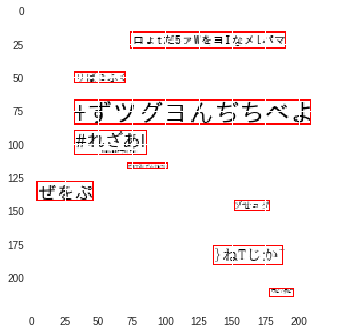

In [83]:
def predict_bboxes(image: np.ndarray, model: tf.keras.Model):
    input = (target_image.astype(np.float32) / 127.5 - 1)[np.newaxis, ...]
    scores, links = model.predict(input)
    instance_map = mask_to_instance_map(scores[0], links[0])
    return instance_map_to_bbox(instance_map, scale=2)


target_image = np.asarray(generate(WIDTH, HEIGHT)[0])
bboxes = predict_bboxes(target_image, model)
for bbox in bboxes:
    cv2.drawContours(target_image, [bbox], 0, (255, 0, 0), 1)
plt.imshow(target_image)

In [0]:
# お掃除
del model

## Recognizer

Detection の次は Recognion です。
Recognition の責務は「切り取られた文字領域が与えられた時、そこに書かれている文字を予測する」ことでした。
今回は入力画像の高さを 32px で揃えることにします。
32×200 とか 32×600 といった横長の画像を受け取って、「あいう」といった文字列を返すことが目標です。

Recognition の概要は以下のようになります。

<ここに良い感じの概要図が入る>

二次元画像 (H×W×3) を適当な CNN に通しつつ、縦方向に pooling (or strided conv) することで (W // 4)×C に変換します。
ここで、C は「扱いたい文字種の数 + 2 (unknown と blank)」です。
出力された (W // 4)×C の行列は、C 方向について softmax をとることで、「横方向の各ピクセルがその文字種である確率を表す行列」とみなすことが出来ます。

--  TODO
だけどピクセル単位の正解ラベルなんてない。
そこで CTC を使います。

まずはモデルの定義からはじめます。

### Define Recognition Network

ResNet-18 をベースにしたネットワークを組みます。
ResNet-18 は `tf.keras.applications` にもないですし、通常 2x2 で pooling するところを 2x1 で pooling するように変更する必要もあるので、自前で実装します。
（https://github.com/raghakot/keras-resnet を参考にさせていただきました）

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, None, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 16, None, 64) 9472        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v2 (BatchNo (None, 16, None, 64) 256         conv2d[0][0]                     
__________________________________________________________________________________________________
re_lu (ReLU)                    (None, 16, None, 64) 0           batch_normalization_v2[0][0]     
______________________________________________________________________________________________

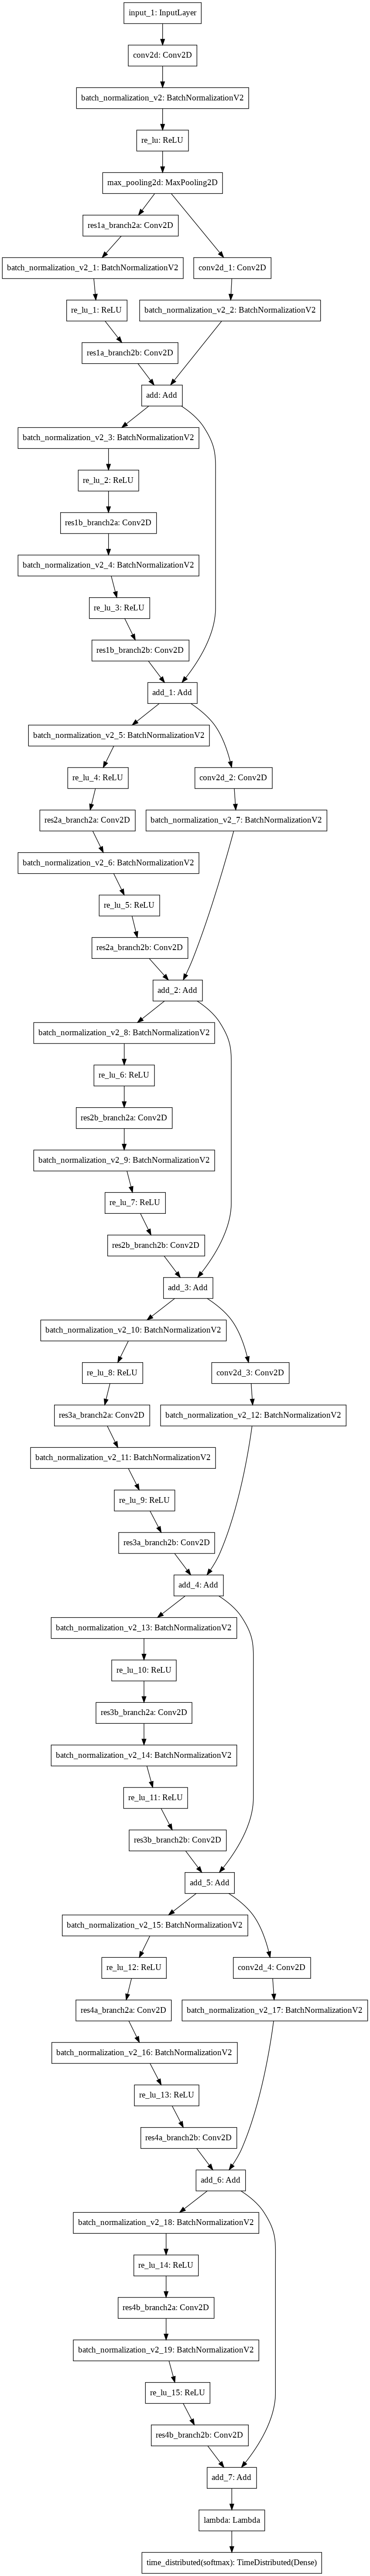

In [7]:
def _bn_relu(x):
    x = L.BatchNormalization()(x)
    return L.ReLU()(x)


def _conv_bn_relu(x, filters, kernel_size, conv_name=None, **conv_params):
    conv_params.setdefault("strides", (1, 1))
    conv_params.setdefault("dilation_rate", (1, 1))
    conv_params.setdefault("kernel_initializer", "he_normal")
    conv_params.setdefault("padding", "same")
    conv_params.setdefault("kernel_regularizer", tf.keras.regularizers.l2(1.0e-4))
    x = L.Conv2D(filters, kernel_size, name=conv_name, **conv_params)(x)
    return _bn_relu(x)


def _bn_relu_conv(x, filters, kernel_size, conv_name=None, **conv_params):
    conv_params.setdefault("strides", (1, 1))
    conv_params.setdefault("dilation_rate", (1, 1))
    conv_params.setdefault("kernel_initializer", "he_normal")
    conv_params.setdefault("padding", "same")
    conv_params.setdefault("kernel_regularizer", tf.keras.regularizers.l2(1.0e-4))
    x = _bn_relu(x)
    x = L.Conv2D(filters, kernel_size, name=conv_name, **conv_params)(x)
    return x

def _shortcut(
    input_feature,
    residual,
    stride_width,
    stride_height,
    conv_name_base=None,
    bn_name_base=None,
):
    """Adds a shortcut between input and residual block and merges them with "sum"
    """
    # Expand channels of shortcut to match residual.
    # Stride appropriately to match residual (width, height)
    # Should be int if network architecture is correctly configured.
    input_shape = input_feature.shape.as_list()
    residual_shape = residual.shape.as_list()

    equal_channels = input_shape[3] == residual_shape[3]

    shortcut = input_feature
    # 1 X 1 conv if shape is different. Else identity.
    if stride_width > 1 or stride_height > 1 or not equal_channels:
        if conv_name_base is not None:
            conv_name_base = conv_name_base + "1"
        shortcut = L.Conv2D(
            filters=residual_shape[3],
            kernel_size=(1, 1),
            strides=(stride_height, stride_width),
            padding="valid",
            kernel_initializer="he_normal",
            kernel_regularizer=tf.keras.regularizers.l2(0.0001),
            name=conv_name_base,
        )(input_feature)
        if bn_name_base is not None:
            bn_name_base = bn_name_base + "1"
        shortcut = L.BatchNormalization(name=bn_name_base)(shortcut)
    return L.add([shortcut, residual])


def _basic_block(
    input_feature,
    filters,
    stage,
    block,
    transition_strides=(1, 1),
    dilation_rate=(1, 1),
    is_first_block_of_first_layer=False,
):
    if block < 27:
        block = "%c" % (block + 97)  # 97 is the ascii number for lowercase 'a'
    conv_name_base = "res" + str(stage) + block + "_branch"
    x = input_feature
    if is_first_block_of_first_layer:
        x = L.Conv2D(
            filters=filters,
            kernel_size=(3, 3),
            strides=transition_strides,
            dilation_rate=dilation_rate,
            padding="same",
            kernel_initializer="he_normal",
            kernel_regularizer=tf.keras.regularizers.l2(1e-4),
            name=conv_name_base + "2a",
        )(x)
    else:
        x = _bn_relu_conv(
            x,
            filters=filters,
            kernel_size=(3, 3),
            strides=transition_strides,
            dilation_rate=dilation_rate,
            conv_name=conv_name_base + "2a",
        )
    x = _bn_relu_conv(
        x,
        filters=filters,
        kernel_size=(3, 3),
        conv_name=conv_name_base + "2b",
    )
    return _shortcut(
        input_feature,
        x,
        stride_width=transition_strides[1],
        stride_height=transition_strides[0],
    )


def _residual_block(
    x,
    filters,
    stage,
    blocks,
    is_first_layer,
    transition_dilation_rates,
    transition_strides,
):
    for i in range(blocks):
        x = _basic_block(
            x,
            filters=filters,
            stage=stage,
            block=i,
            transition_strides=transition_strides[i],
            dilation_rate=transition_dilation_rates[i],
            is_first_block_of_first_layer=(is_first_layer and i == 0),
        )
    return x


def create_recognition_model(input_shape, n_vocab):
    input = tf.keras.layers.Input(shape=input_shape)
    x = _conv_bn_relu(
        input, filters=64, kernel_size=(7, 7), strides=(2, 2)
    )
    x = L.MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding="same")(x)
    x = _residual_block(
        x,
        128,
        stage=1,
        blocks=2,
        is_first_layer=True,
        transition_strides=[(1, 1), (1, 1)],
        transition_dilation_rates=[1, 1],
    )
    x = _residual_block(
        x,
        256,
        stage=2,
        blocks=2,
        is_first_layer=False,
        transition_strides=[(2, 1), (1, 1)],
        transition_dilation_rates=[1, 1],
    )
    x = _residual_block(
        x,
        512,
        stage=3,
        blocks=2,
        is_first_layer=False,
        transition_strides=[(2, 1), (1, 1)],
        transition_dilation_rates=[1, 1],
    )
    x = _residual_block(
        x,
        1024,
        stage=4,
        blocks=2,
        is_first_layer=False,
        transition_strides=[(2, 1), (1, 1)],
        transition_dilation_rates=[1, 1],
    )
    x = L.Lambda(lambda fm: tf.squeeze(fm, axis=1))(x)
    x = L.TimeDistributed(L.Dense(n_vocab + 1, activation="softmax", name="softmax"))(x)
    return tf.keras.Model(input, x)


recognizer = create_recognition_model(input_shape=(32, None, 3), n_vocab=len(CHARACTERS) + 1)
recognizer.summary()
tf.keras.utils.plot_model(recognizer)

### Setup input pipeline

Recognizer の学習に必要なのは、「入力画像」「入力画像の横幅」「正解文字列（を ID 列にしたもの）」「正解文字列の長さ」です。

In [29]:
RECOGNITION_HEIGHT = 32
CHAR_MAP = {c: i + 1 for i, c in enumerate(CHARACTERS)}
UNKNOWN = 1

from concurrent.futures import ProcessPoolExecutor

def _recognition_generator_map_fn(args):
    image, bboxes = args
    img = np.asarray(image)
    results = []
    for bbox in bboxes:
        cropped = img[bbox.ymin:bbox.ymax, bbox.xmin:bbox.xmax]
        h, w = cropped.shape[0], cropped.shape[1]
        resized = cv2.resize(cropped, (int(w * RECOGNITION_HEIGHT / h), RECOGNITION_HEIGHT))
        resized_width = resized.shape[1]
        text_length = len(bbox.text)
        if resized_width // 4 < text_length:
            continue
        if resized_width > 32 * 6:
            continue
        text = [CHAR_MAP.get(c, UNKNOWN) for c in bbox.text]
        results.append((resized, {"width": resized_width, "text": text, "text_length": text_length}))
    return results

recognition_examples = []
with ProcessPoolExecutor() as pool:
    for examples in pool.map(_recognition_generator_map_fn, zip(train_images, train_bboxes)):
        recognition_examples.extend(examples)
print(len(recognition_examples))
        
def recognition_data_generator_fn():
    def fn():
        for example in recognition_examples:
            yield example
    return fn


def make_recognition_dataset(batch_size, training=False):
    dataset = tf.data.Dataset.from_generator(
        recognition_data_generator_fn(),
        output_types=(tf.uint8, {"width": tf.int32, "text": tf.int32, "text_length": tf.int32})
    )
    dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
    if training:
        dataset = dataset.shuffle()
    dataset = dataset.padded_batch(
        batch_size, 
        padded_shapes=((32, None, 3), {"width": (), "text": (None,), "text_length": ()}),
    )
    def map_fn(image, labels):
        return tf.cast(image, tf.float32) / 127.5 -1, labels
    dataset = dataset.map(map_fn, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    return dataset

5547


### Define loss function

In [0]:
@tf.function(input_signature=(
    tf.TensorSpec(shape=(None, None, None), dtype=tf.float32),
    tf.TensorSpec(shape=(None, None), dtype=tf.int32),
    tf.TensorSpec(shape=(None,), dtype=tf.int32),
    tf.TensorSpec(shape=(None,), dtype=tf.int32),
))
def recognition_loss(y_pred, y_true, input_width, text_length):
    pred_length = input_width // 4
    # tf.print(y_pred, y_true, text_length)
    cost = tf.keras.backend.ctc_batch_cost(y_true, y_pred, pred_length[..., tf.newaxis], text_length[..., tf.newaxis])
    return tf.reduce_mean(cost)

### Train Recognizer

In [53]:
model = create_recognition_model(input_shape=(RECOGNITION_HEIGHT, None, 3), n_vocab=len(CHARACTERS) + 1)
optimizer = tf.keras.optimizers.Nadam(1e-4)
losses = tf.keras.metrics.Mean(name="reconition/loss")
model.output

<tf.Tensor 'time_distributed_6/Reshape_1:0' shape=(None, None, 261) dtype=float32>

In [0]:
@tf.function
def train_step(images, labels):
    with tf.GradientTape() as tape:
        y_pred = model(images, training=True)
        loss = recognition_loss(y_pred, labels["text"], labels["width"], labels["text_length"])
    losses(loss)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    
    
def train(dataset):
    for images, labels in dataset:
        train_step(images, labels)
        if tf.equal(optimizer.iterations % 10, 0):
            tf.print("Step", optimizer.iterations, ": Loss :", losses.result())
        
        
dataset = make_recognition_dataset(32)
for epoch in range(100):
    print("Epoch {}".format(epoch))
    train(dataset)
    tf.print("Step", optimizer.iterations, ": Loss :", losses.result())

Epoch 0
Step 10 : Loss : 47.6796188
Step 20 : Loss : 39.6931725
Step 30 : Loss : 36.2429619


In [0]:
model.save_weights(os.path.join(rootdir, "recognizer_weights.h5"))

{'width': 75, 'text': [131, 95], 'text_length': 2}


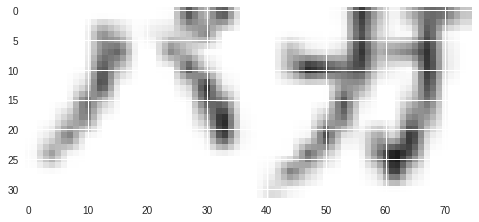

In [48]:
n = np.random.randint(0, len(recognition_examples))
img, labels = recognition_examples[n]
print(labels)
plt.imshow(img)

In [49]:
input = (img.astype(np.float32) / 127.5 - 1.0)[np.newaxis, :, :, :]
pred = model.predict(input)
print(pred)
decoded, _ = tf.keras.backend.ctc_decode(pred, [input.shape[2] // 4])
print(decoded)
predicted_chars = []
for idx in decoded[0][0].numpy():
    predicted_chars.append(CHARACTERS[idx])
print("".join(predicted_chars))

[[[7.7317985e-11 2.3360839e-08 5.1037685e-09 ... 3.2604191e-08
   4.5362547e-08 9.9996936e-01]
  [7.1482964e-10 7.0480208e-09 4.6572315e-09 ... 1.4608526e-09
   7.8596365e-09 4.5323443e-02]
  [5.6736196e-11 7.4526281e-11 6.7834593e-10 ... 1.9811340e-10
   4.1882869e-11 8.5369486e-01]
  ...
  [3.2060816e-17 1.2339251e-17 3.9732550e-14 ... 4.2359911e-14
   4.0068589e-16 1.0000000e+00]
  [1.6518411e-18 4.7421689e-17 5.7246444e-17 ... 1.2617921e-14
   4.1635071e-14 1.0000000e+00]
  [6.9648031e-13 4.4700233e-13 3.2206689e-13 ... 6.0562675e-12
   8.2922853e-12 1.0000000e+00]]]
[<tf.Tensor: id=270363, shape=(1, 2), dtype=int64, numpy=array([[131,  95]])>]
パキ


In [51]:
pred.shape

(1, 18, 261)